## Tree Segmentation

In [32]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from fastai.metrics import *

rand_seed = 42

datapath = datapath = "/home/derekdb/notebooks/uw-geohack-challenge/data"
path = Path(datapath)/'semantic_drone_dataset'
path_lbl_semantic = path/'label_images_semantic' #path for semantic masks
path_lbl_bin = path/'label_images_bin' # path for binary masks
path_lbl_bin_resized = path/'label_images_bin_resized'
path_img = path/'original_images' # path for original images
path_img_resized = path/'original_images_resized' # resize to work with patches
path_valid = path/'valid.txt'
path_eval = Path(datapath)/'eval_data'

## Datasets

In [33]:
# load a mask
fnames = get_image_files(path_lbl_bin_resized)
mask = open_mask(fnames[0])
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([448, 672]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [3]:
get_y_fn = lambda x: (path_lbl_bin_resized/x.stem).with_suffix('.png')

In [4]:
codes = array(['Background', 'Tree'])

In [5]:
size = src_size//2

In [6]:
# learn.destroy()
gc.collect()
torch.cuda.empty_cache()
free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4

print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11429MB of GPU RAM free


In [7]:
src = (SegmentationItemList.from_folder(path_img_resized)
       .split_by_fname_file(str(path_valid))
       .label_from_func(get_y_fn, classes=codes))

In [8]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

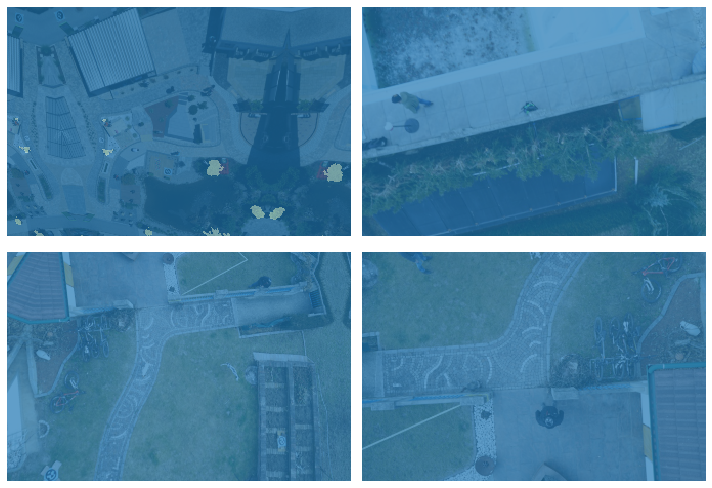

In [9]:
data.show_batch(2, figsize=(10,7), alpha=0.7)

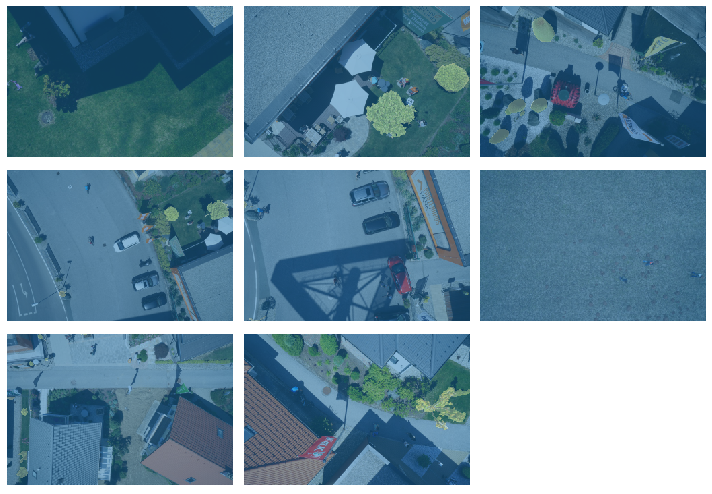

In [10]:
data.show_batch(5, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [11]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Background']
void_code


0

In [12]:
def acc(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()



In [13]:
metrics=acc
# metrics=accuracy

wd=1e-2

In [14]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [15]:
# lr_find(learn)


In [16]:
# learn.recorder.plot()

In [17]:
lr=1e-3

In [18]:
# learn.fit_one_cycle(10, slice(lr), pct_start=0.9) 

In [19]:
# learn.save('stage-1')

In [20]:
# learn.load('stage-1');

In [21]:
# learn.show_results(rows=3, figsize=(8,9), alpha=0.9)

In [22]:
# learn.unfreeze()

In [23]:
# lrs = slice(lr/400,lr/4)

In [24]:
# learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [25]:
# learn.save('stage-2');

In [26]:
# learn.show_results(rows=5, figsize=(8,9), alpha=0.9)

## Try on validation data

In [27]:
learn.load('stage-2');

In [39]:
# path_patches = path_eval/'patches'

fnames = get_image_files(path_img_resized)


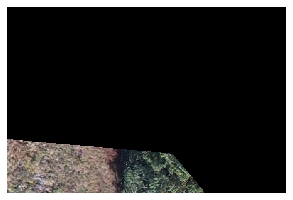

In [69]:
img_f = '/home/derekdb/notebooks/uw-geohack-challenge/data/eval_data/patches/ortho_eval_11_6.tif'
# img_f = fnames[10]
img = open_image(Path(img_f))
img.show(figsize=(5,5))


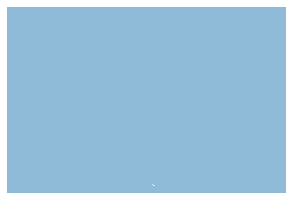

In [70]:
prediction = learn.predict(img)
prediction[0].show(figsize=(5,5))

In [56]:
prediction[0].save(path_eval/'test.png')

In [ ]:
# predict all the patches and save results to a separate folder
def predict_patches(fns):
    for fn in fns:
        img = open_image(fn)
        prediction = learn.predict(img)
        

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [57]:
# learn.destroy() 

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
# if free > 8200: bs=3
# else:           bs=1
bs = 1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=1, have 10960MB of GPU RAM free


In [58]:
data = (src.transform(get_transforms(flip_vert=True), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [59]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [60]:
learn.load('stage-2');

In [61]:
lr_find(learn)

epoch,train_loss,valid_loss,acc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


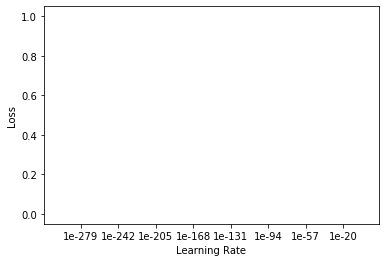

In [62]:
learn.recorder.plot()

In [ ]:
lr=1e-5

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-5, 1e-4)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

In [ ]:
path = Path(datapath)/'eval_data/images'
fnames = get_image_files(path)
fnames[0]

In [ ]:
fname = "/home/derekdb/notebooks/uw-geohack-challenge/data/semantic_drone_dataset/test/ortho_eval_10_1.tif"

In [ ]:
temp = open_image(fname)
temp.show(figsize=(5,5))

In [ ]:
prediction = learn.predict(temp)
prediction[0].show(figsize=(5,5))

## fin